In [1]:
import os
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from segments.utils import load_image_from_url, load_label_bitmap_from_url, get_semantic_bitmap
from segments import SegmentsClient
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.16.1


In [3]:
# Use your Segments.ai API key
API_folder = "C:/Users/alex/Desktop/API_keys/"
API_file = "Segments_API.txt"
api_key = open(API_folder + API_file, "r").readline().strip()
client = SegmentsClient(api_key)
dataset_identifier = 'davis_alexander/TEM_Project4'
dataset = client.get_dataset(dataset_identifier)
segments_data = client.get_samples(dataset_identifier)

In [4]:
print(segments_data)

[Sample(uuid='c08e6fd0-ae77-48a9-a0a8-99806351df5f', name='AE-002_000004.jpg', attributes=ImageSampleAttributes(image=URL(url='https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/davis_alexander/847f6f93-5a86-4560-b63e-35d811b54405.jpg')), metadata={}, created_at='2024-07-02T18:30:13.031662Z', created_by='davis_alexander', assigned_labeler=None, assigned_reviewer=None, comments=[], priority=0.0, label=None, issues=None, dataset_full_name=None), Sample(uuid='24e39001-3a4e-4616-bfe8-23829c87b6a5', name='AE-002_000005.jpg', attributes=ImageSampleAttributes(image=URL(url='https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/davis_alexander/66e095fa-db31-456e-a518-1180d3841717.jpg')), metadata={}, created_at='2024-07-02T18:30:13.080483Z', created_by='davis_alexander', assigned_labeler=None, assigned_reviewer=None, comments=[], priority=0.0, label=None, issues=None, dataset_full_name=None), Sample(uuid='0bee0a6a-f956-4d49-8954-594472d86128', name='AE-002_000008.jpg', attributes=Im

In [5]:
# Load the COCO JSON file
coco_file = './coco_format_dataset.json'
with open(coco_file, 'r') as f:
    coco_data = json.load(f)

# Verify the loaded data
print(coco_data.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [6]:
print(coco_data['info'])
print(coco_data['categories'])
print(coco_data['images'][0])
print(coco_data['annotations'][0])
print(coco_data['images'][0]['file_name'])

{'description': 'TEM_Project4', 'version': 'TEM_V02', 'year': 2024, 'contributor': 'Alex Davis', 'date_created': '2024-07-26'}
[{'id': 1, 'name': 'Rods', 'supercategory': 'none'}, {'id': 3, 'name': 'Spheres', 'supercategory': 'none'}]
{'id': 1, 'file_name': 'AS-005_000008.jpg', 'height': 1180, 'width': 1280, 'license': 1, 'date_captured': '2024-07-26 00:00:00'}
{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': [[541, 870, 540, 871, 539, 871, 538, 872, 537, 872, 536, 873, 535, 873, 534, 874, 533, 874, 532, 875, 532, 876, 530, 878, 530, 879, 529, 880, 529, 881, 528, 882, 528, 890, 529, 891, 529, 893, 531, 895, 531, 896, 535, 900, 535, 901, 536, 901, 540, 905, 541, 905, 546, 910, 547, 910, 551, 914, 553, 914, 555, 916, 555, 917, 556, 918, 557, 918, 559, 920, 560, 920, 563, 923, 564, 923, 567, 926, 568, 926, 571, 929, 572, 929, 574, 931, 575, 931, 576, 932, 576, 933, 578, 935, 579, 935, 581, 937, 582, 937, 583, 938, 584, 938, 585, 939, 586, 939, 588, 941, 589, 941, 590, 942, 591, 

train_annotations={
    'info': coco_data['info'],
    'categories': coco_data['categories']
}
                
test_annotations={
    'info': coco_data['info'],
    'categories': coco_data['categories']
}

val_annotations={
    'info': coco_data['info'],
    'categories': coco_data['categories']
}


In [7]:
def get_coco_data(file_name):
    for index, image in enumerate(coco_data['images']):
        if image['file_name'] == file_name:
            return image, coco_data['annotations'][index]

    return None

In [8]:
print(len(segments_data))
print(type(segments_data))
print(segments_data[0])
print(segments_data[0].name)

116
<class 'list'>
uuid='c08e6fd0-ae77-48a9-a0a8-99806351df5f' name='AE-002_000004.jpg' attributes=ImageSampleAttributes(image=URL(url='https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/davis_alexander/847f6f93-5a86-4560-b63e-35d811b54405.jpg')) metadata={} created_at='2024-07-02T18:30:13.031662Z' created_by='davis_alexander' assigned_labeler=None assigned_reviewer=None comments=[] priority=0.0 label=None issues=None dataset_full_name=None
AE-002_000004.jpg


In [9]:
def image_splitter(sample):
    label = client.get_label(sample.uuid, labelset='ground-truth')

    # Load the labels as numpy arrays
    image = load_image_from_url(sample.attributes.image.url)
    instance_bitmap = load_label_bitmap_from_url(label.attributes.segmentation_bitmap.url)

    coco_image_data, coco_annotations = get_coco_data(sample.name)

    # Convert annotations to dictionaries if they are objects
    annotations = [annotation.__dict__ for annotation in label.attributes.annotations]

    # Generate semantic bitmap
    semantic_bitmap = get_semantic_bitmap(instance_bitmap, annotations)
    return image, instance_bitmap, semantic_bitmap, coco_image_data, coco_annotations, sample.name

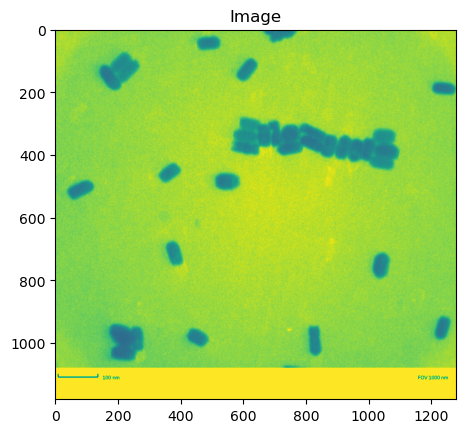

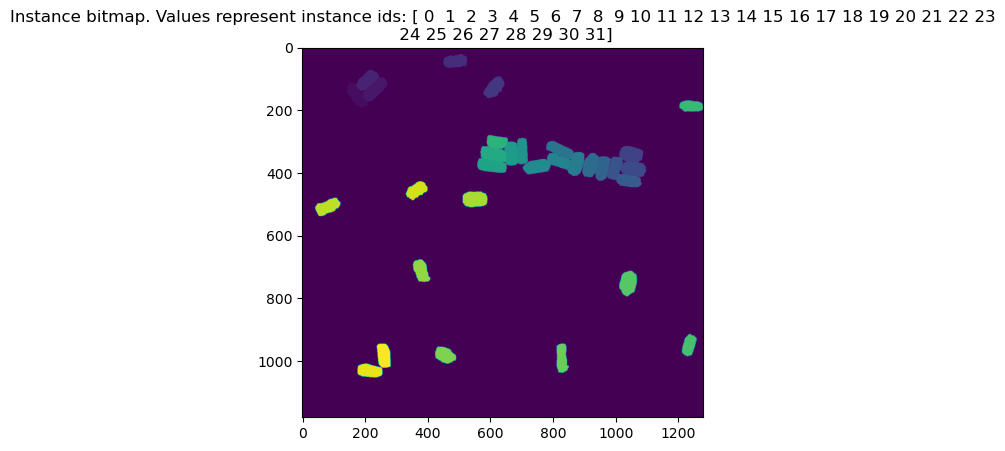

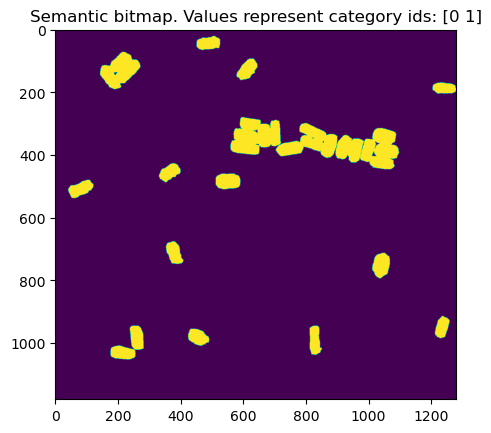

{'id': 52, 'image_id': 4, 'category_id': 1, 'segmentation': [[972, 927, 968, 931, 967, 931, 966, 932, 965, 932, 965, 934, 964, 935, 964, 936, 963, 937, 963, 938, 962, 939, 962, 941, 961, 942, 961, 943, 960, 944, 960, 945, 959, 946, 959, 947, 958, 948, 958, 950, 957, 951, 957, 953, 956, 954, 956, 955, 955, 956, 955, 957, 954, 958, 954, 959, 953, 960, 953, 961, 952, 962, 951, 962, 951, 963, 950, 964, 950, 967, 949, 968, 949, 969, 948, 970, 948, 971, 947, 972, 947, 973, 946, 974, 946, 975, 945, 976, 945, 977, 944, 978, 944, 981, 943, 982, 943, 983, 942, 984, 942, 985, 941, 986, 941, 987, 940, 988, 940, 989, 939, 990, 939, 991, 938, 992, 938, 1001, 937, 1002, 937, 1006, 938, 1007, 938, 1008, 942, 1012, 942, 1014, 943, 1014, 944, 1015, 945, 1015, 947, 1017, 948, 1017, 949, 1018, 960, 1018, 962, 1016, 963, 1016, 966, 1013, 966, 1012, 967, 1011, 969, 1011, 969, 1009, 970, 1008, 970, 1006, 971, 1005, 971, 1004, 972, 1003, 972, 1002, 973, 1001, 973, 1000, 974, 999, 974, 996, 975, 995, 975, 994,

In [10]:
image, instance_bitmap, semantic_bitmap, coco_image_data, coco_annotations, name = image_splitter(segments_data[3])
# Visualize
plt.imshow(image)
plt.title('Image')
plt.show()

plt.imshow(instance_bitmap)
plt.title(f'Instance bitmap. Values represent instance ids: {np.unique(instance_bitmap)}')
plt.show()

plt.imshow(semantic_bitmap)
plt.title(f'Semantic bitmap. Values represent category ids: {np.unique(semantic_bitmap)}')
plt.show()

print(coco_annotations)

In [11]:
print(name)

AS-002_000002.jpg


In [12]:
dataset_length = len(segments_data)

# Split the dataset into train and test
splits = [0.7, 0.2, 0.1] # Train, validation, test

# Calculate the sizes of the splits
train_size = int(splits[0] * dataset_length)
val_size = int(splits[1] * dataset_length)
test_size = dataset_length - train_size - val_size

# Shuffle the dataset
np.random.seed(42)
indices = np.arange(dataset_length)
np.random.shuffle(indices)

# Split the dataset into train, validation and test sets
train_indices, temp_indices = train_test_split(indices, test_size=(val_size + test_size))
val_indices, test_indices = train_test_split(temp_indices, test_size=test_size)

# Create output folders
output_folder = {'train': './data/images/train', 
                 'val': './data/images/val', 
                 'test': './data/images/test'}

for folder in output_folder.values():
    os.makedirs(folder, exist_ok=True)

# Save the images and labels
def process_and_save(set_name, indices):
    annotations_dict = {
        'info': coco_data['info'],
        'categories': coco_data['categories'],
        'images': [],
        'annotations': []
    }

    for i in indices:
        image, instance_bitmap, semantic_bitmap, coco_image_data, coco_annotations, name = image_splitter(segments_data[i])
        
        # Save images
        plt.imsave(os.path.join(output_folder[set_name], f'{name[:-4]}.jpg'), image, cmap='gray')
        plt.imsave(os.path.join(output_folder[set_name], f'{name[:-4]}_instance.jpg'), instance_bitmap, cmap='viridis')
        plt.imsave(os.path.join(output_folder[set_name], f'{name[:-4]}_semantic.jpg'), semantic_bitmap, cmap='coolwarm')

        annotations_dict['images'].append(coco_image_data)
        annotations_dict['annotations'].append(coco_annotations)

    return annotations_dict
    #with open(f'./data/annotations/{set_name}_annotations.json', 'w') as filename:
    #    json.dump(annotations_list, filename, indent=4)

train_annotations = process_and_save('train', train_indices)
val_annotations = process_and_save('val', val_indices)
test_annotations = process_and_save('test', test_indices)

with open(f'./data/annotations/train_annotations2.json', 'w') as filename:
    json.dump(train_annotations, filename, indent=4)
with open(f'./data/annotations/test_annotations2.json', 'w') as filename:
    json.dump(test_annotations, filename, indent=4)
with open(f'./data/annotations/val_annotations2.json', 'w') as filename:
    json.dump(val_annotations, filename, indent=4)

In [11]:
print(train_annotations)

{'info': {'description': 'TEM_Project4', 'version': 'TEM_V02', 'year': 2024, 'contributor': 'Alex Davis', 'date_created': '2024-07-26'}, 'categories': [{'id': 1, 'name': 'Rods', 'supercategory': 'none'}, {'id': 3, 'name': 'Spheres', 'supercategory': 'none'}], 'images': [{'id': 6, 'file_name': 'CN-014_000005.jpg', 'height': 1180, 'width': 1280, 'license': 1, 'date_captured': '2024-07-26 00:00:00'}, {'id': 32, 'file_name': 'CD-074_000008.jpg', 'height': 1180, 'width': 1280, 'license': 1, 'date_captured': '2024-07-26 00:00:00'}, {'id': 42, 'file_name': 'AS-003_000011.jpg', 'height': 1180, 'width': 1280, 'license': 1, 'date_captured': '2024-07-26 00:00:00'}, {'id': 58, 'file_name': 'CD-074_000010.jpg', 'height': 1180, 'width': 1280, 'license': 1, 'date_captured': '2024-07-26 00:00:00'}, {'id': 11, 'file_name': 'AE-002_000008.jpg', 'height': 1180, 'width': 1280, 'license': 1, 'date_captured': '2024-07-26 00:00:00'}, {'id': 83, 'file_name': 'AE-002_000005.jpg', 'height': 1180, 'width': 1280,